In [1]:
from datetime import datetime
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from PIL import Image
from tqdm import tqdm
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
load_dotenv()
from models.modeling_florence2 import Florence2ForConditionalGeneration
from models.processing_florence2 import Florence2Processor
device = torch.device("cuda")


/home/muddassir/miniforge3/envs/thesisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muddassir/miniforge3/envs/thesisenv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
PROMPT = "<AO>"
# CHECKPOINT_PATH = "/home/docanalysis/florence2-training/models"
CHECKPOINT_PATH="/home/muddassir/Desktop/LayoutAnalysis/server_data/experiments/50epoch/models"
# CHECKPOINT_PATH="/home/muddassir/Desktop/LayoutAnalysis/server_data/experiments/50epoch/checkpoint-8514"
print(CHECKPOINT_PATH)
config_f = AutoConfig.from_pretrained(
    CHECKPOINT_PATH, trust_remote_code=True
)
config_f.vision_config.model_type = "davit"
config_f.vision_config.in_chans = 3
model_f = (
    AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        trust_remote_code=True,
        config=config_f,
        torch_dtype=torch.float16,
        ignore_mismatched_sizes=True,
    )
    .to(device)
    .eval()
)
processor_f = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

/home/muddassir/Desktop/LayoutAnalysis/server_data/experiments/50epoch/models
use_pretrain_weight: load model from: /home/muddassir/Desktop/LayoutAnalysis/code_modularized/models/word_embeddings.pt


In [3]:
id2label = {
    1: "Caption",
    2: "Footnote",
    3: "Formula",
    4: "ListItem",
    5: "PageFooter",
    6: "PageHeader",
    7: "Picture",
    8: "SectionHeader",
    9: "Table",
    10: "Text",
    11: "Title",
}
label2id = {v:k for k,v in id2label.items()}
prompts = ["<AO>",
            "<CAP>",
            "<FTN",
            "<FRM>",
            "<LST>",
            "<PGF>",
            "<PGH>",
            "<PIC>",
            "<SHD>",
            "<TAB>",
            "<TXT>",
            "<TTL>",]

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Mapping from category id to category name
CATEGORY_ID_TO_NAME = {
    1: "Caption",
    2: "Footnote",
    3: "Formula",
    4: "List-item",
    5: "Page-footer",
    6: "Page-header",
    7: "Picture",
    8: "Section-header",
    9: "Table",
    10: "Text",
    11: "Title"
}

def display_image_with_boxes(x):
    """
    Display an image with bounding boxes and category names.

    Parameters:
    x (dict): A dictionary containing "image", "boxes", and "category_ids"
    """
    # Load image
    image = x["image"]
    
    # Convert to numpy array if needed
    if isinstance(image, Image.Image):
        image = np.array(image)

    boxes = x["boxes"]
    category_ids = x["category_ids"]

    # Create plot
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for box, cat_id in zip(boxes, category_ids):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        # Draw rectangle
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Add label
        label = CATEGORY_ID_TO_NAME.get(cat_id, "Unknown")
        ax.text(xmin, ymin - 5, label, color='white',
                fontsize=10, bbox=dict(facecolor='red', alpha=0.7))

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [5]:
from datasets import load_from_disk
dataset = load_from_disk("/home/muddassir/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val")

In [6]:
dataset[1].keys()

dict_keys(['image', 'category_ids', 'image_id', 'boxes', 'width', 'height', 'bbox_str', 'class_strs', 'ocr_words', 'ocr_boxes', 'input_ids', 'subword_bboxs'])

In [7]:
def run_example(task_prompt, example, max_new_tokens=128, input_text: str = None):
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    image = example["image"]
    input_ids = torch.tensor(example['input_ids'])
    bbox = torch.tensor(example['subword_bboxs'])
    inputs = processor_f(text=prompt,images=image, return_tensors="pt")
    inputs = {**inputs, "grid_data":[{"input_ids": input_ids, "bbox": bbox}]}
    generated_ids = model_f.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values = inputs["pixel_values"].half().to(device),
        grid_data = inputs['grid_data'],
        max_new_tokens=max_new_tokens,
        early_stopping=False,
        do_sample=False,
        num_beams=3
        )
    
    generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
    print(generated_text)
    parsed_answer = processor_f.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )
    return parsed_answer
def plot_bounding_boxes(image,bboxs, labels, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for box, label in zip(bboxs, labels):
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=0.5, edgecolor='r', facecolor='g',alpha=0.3)
        #add class name
        ax.text(box[0], box[1],label, fontsize=12, color='red')
        ax.add_patch(rect)
    plt.show()

In [8]:
prompts = ["<AO>",
            "<CAP>",
            "<FTN",
            "<FRM>",
            "<LST>",
            "<PGF>",
            "<PGH>",
            "<PIC>",
            "<SHD>",
            "<TAB>",
            "<TXT>",
            "<TTL>",]

['Locate the objects with category name in the image. SectionHeader']
{'input_ids': tensor([[    0,   574, 22486,     5,  8720,    19,  4120,   766,    11,     5,
          2274,     4,  7162, 49474,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
</s><s>SectionHeader<loc_66><loc_168><loc_269><loc_179><loc_66><loc_443><loc_300><loc_455></s>


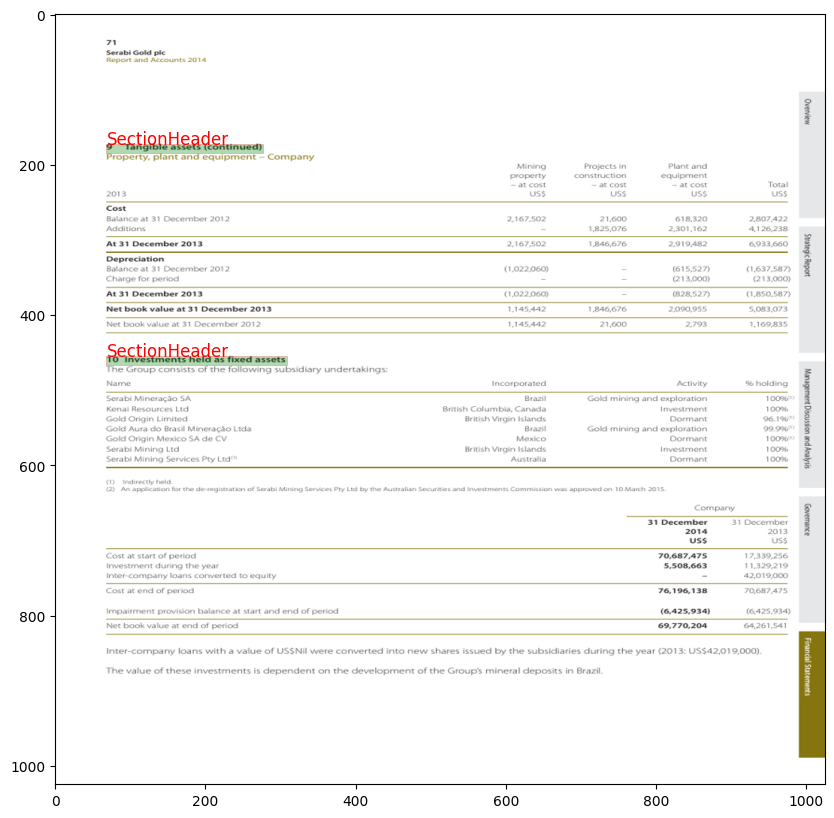

In [9]:
i=854
Prompt = "<SHD>"
out = run_example(Prompt, dataset[i], input_text=None)
plot_bounding_boxes(dataset[i]['image'], out[Prompt]['bboxes'], out[Prompt]['labels'])

In [16]:
x=dataset[854]

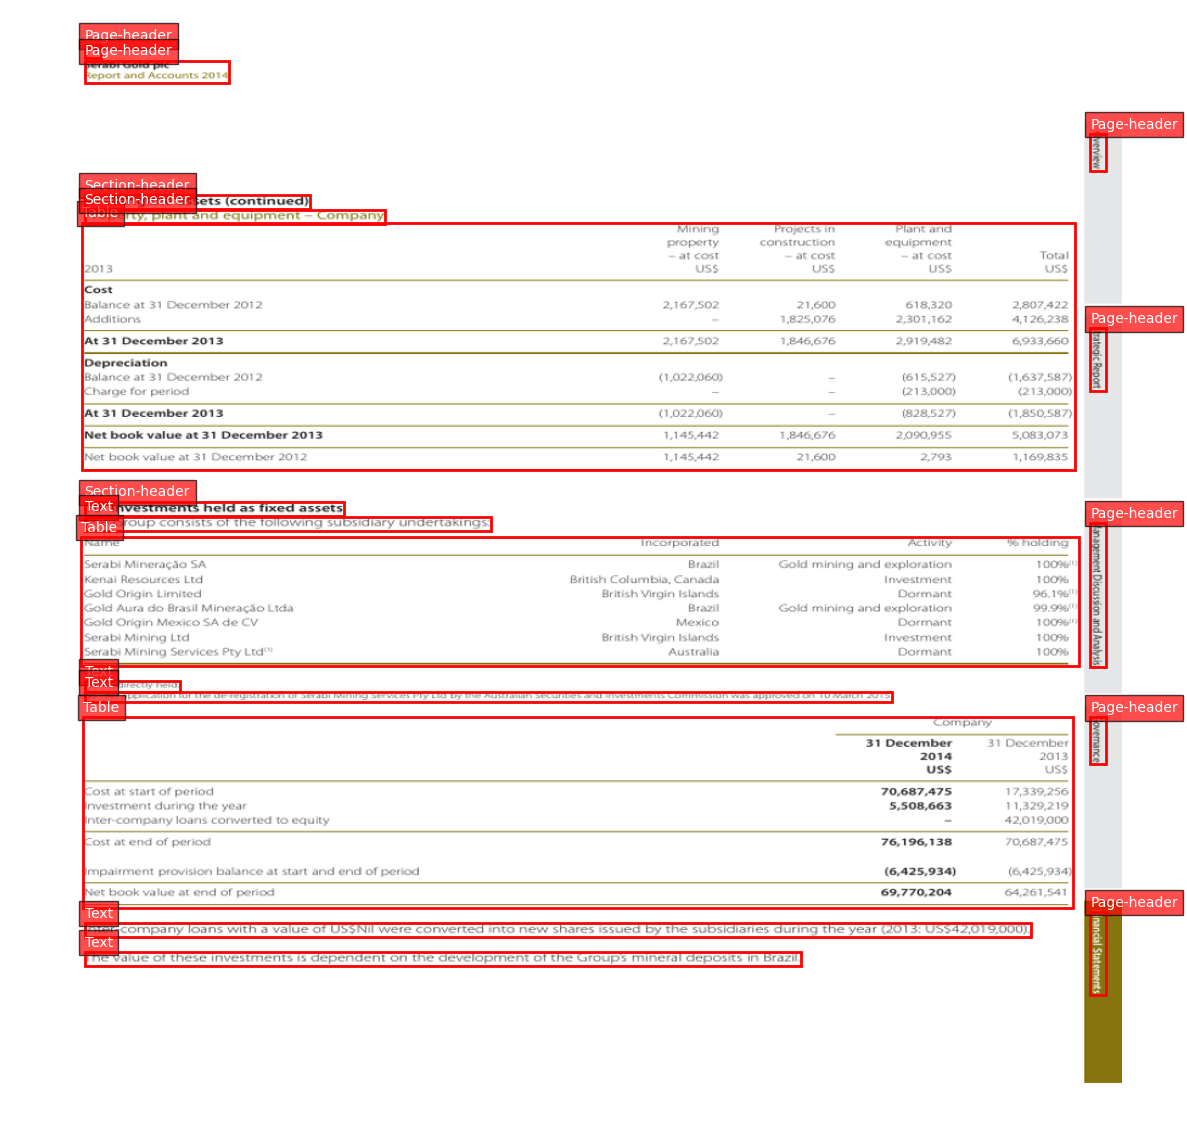

In [17]:
display_image_with_boxes(x)

In [ ]:
print(x["category_ids"])
print(x["boxes"])

[6, 6, 10, 10, 10, 10, 10, 10, 5, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 9, 8]
[[138.5135498046875, 47.501224517822266, 365.0729675292969, 59.50627899169922], [66.83280181884766, 22.406631469726562, 110.81088256835938, 76.4293212890625], [127.43244171142578, 69.79096221923828, 303.630126953125, 80.29533386230469], [110.81088256835938, 137.76988220214844, 508.9762878417969, 165.07327270507812], [548.51416015625, 306.15325927734375, 947.5191650390625, 364.05328369140625], [548.51416015625, 375.23492431640625, 947.6896362304688, 433.135009765625], [110.81088256835938, 652.2392578125, 513.271728515625, 786.719970703125], [570.6673583984375, 652.2433471679688, 947.5418701171875, 758.241455078125], [56.88594055175781, 988.6177368164062, 401.9242858886719, 1005.1246948242188], [110.81088256835938, 796.71533203125, 509.29034423828125, 840.4963989257812], [548.51416015625, 764.6708984375, 948.0364379882812, 840.4950561523438], [110.81088256835938, 175.09388732910156, 510.11761474609375, 264.747711181

In [14]:
out

{'<SHD>': {'bboxes': [[48.6875,
    101.98749542236328,
    350.0375061035156,
    140.9375],
   [48.6875, 170.66249084472656, 222.9375, 183.9875030517578],
   [48.6875, 224.98748779296875, 140.9375, 237.28749084472656],
   [48.6875, 278.2875061035156, 159.3874969482422, 290.5874938964844],
   [48.6875, 518.1375122070312, 138.8874969482422, 531.4624633789062],
   [48.6875, 625.7625122070312, 221.91249084472656, 638.0625]],
  'labels': ['SectionHeader',
   'SectionHeader',
   'SectionHeader',
   'SectionHeader',
   'SectionHeader',
   'SectionHeader']}}

In [21]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time # Optional: for timing inference

# --- User Environment Setup (Ensure these are loaded/defined) ---
# These variables and functions MUST be defined in your execution environment
# before running the script below.

# from datasets import load_from_disk
# dataset = load_from_disk("/path/to/your/dataset/test") # Load your actual dataset

# id2label = { ... } # Your actual id2label mapping
# label2id = {v: k for k, v in id2label.items()} # Your actual label2id mapping

# model_f = ... # Your loaded model
# processor_f = ... # Your loaded processor
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def run_example(task_prompt, example, max_new_tokens=128, input_text: str = None):
#     # --- Your actual run_example function as provided in the prompt ---
#     prompt = task_prompt
#     if input_text is not None:
#         prompt += input_text
#     image = example["image"]
#     # Ensure input_ids and subword_bboxs are handled correctly if needed by your processor/model
#     input_ids = torch.tensor(example.get('input_ids', [])) # Use .get for safety
#     bbox = torch.tensor(example.get('subword_bboxs', [])) # Use .get for safety

#     # Adapt processor call based on its actual signature
#     inputs = processor_f(text=prompt, images=image, return_tensors="pt")

#     # Add grid_data if your model expects it in this format
#     if input_ids.numel() > 0 and bbox.numel() > 0: # Check if tensors are not empty
#          inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
#     else:
#          # Handle cases where grid_data might not be needed or available
#          # Depending on your model, you might pass an empty dict or omit it
#          inputs = {**inputs} # Pass other inputs as needed

#     # Move inputs to the correct device
#     input_ids_dev = inputs["input_ids"].to(device)
#     pixel_values_dev = inputs["pixel_values"].half().to(device) # Use .half() if model expects fp16
#     grid_data_dev = inputs.get('grid_data') # Keep grid_data on CPU or move if necessary

#     # Prepare generation arguments
#     gen_kwargs = {
#         "input_ids": input_ids_dev,
#         "pixel_values": pixel_values_dev,
#         "max_new_tokens": max_new_tokens,
#         "early_stopping": False,
#         "do_sample": False,
#         "num_beams": 3,
#     }
#     # Only add grid_data to generation kwargs if it exists and is needed
#     if grid_data_dev:
#         gen_kwargs["grid_data"] = grid_data_dev

#     generated_ids = model_f.generate(**gen_kwargs)

#     generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
#     # print(f"Generated text for {task_prompt}: {generated_text}") # Optional debug print
#     parsed_answer = processor_f.post_process_generation(
#         generated_text, task=task_prompt, image_size=(image.width, image.height)
#     )
#     return parsed_answer
# --- End of User Environment Setup ---


# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5
# Limit the number of samples for testing (set to None to use the full dataset)
NUM_SAMPLES = None # e.g., 100

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the union area
    # Add a small epsilon to avoid division by zero
    unionArea = boxAArea + boxBArea - interArea + 1e-6

    # Compute the IoU
    iou = interArea / unionArea
    return iou

def evaluate_layout_model(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model on the provided dataset. Only prompts for classes
    present in the ground truth of each image.

    Args:
        dataset: The dataset object (Hugging Face dataset).
        prompt_map: Dictionary mapping prompt strings to label strings (e.g., "<TXT>": "Text").
        label_map_rev: Dictionary mapping label strings to prompt strings (e.g., "Text": "<TXT>").
        iou_threshold: The IoU threshold for matching predictions to ground truth.
        num_samples: Max number of samples to evaluate on (or None for all).

    Returns:
        A dictionary containing evaluation results (TP, FP, FN per class).
    """
    results = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            # Handle potential variations in box/category format
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # Ensure gt_boxes_all is a list of lists/tensors
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                 print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                 # Optionally get sample ID if available: example.get('image_id', 'Unknown')
                 continue

            # Ensure gt_category_ids is a list of integers
            if not isinstance(gt_category_ids, list) or (gt_category_ids and not isinstance(gt_category_ids[0], int)):
                 # Handle nested list case like [[1, 2, 3]] if necessary
                 if isinstance(gt_category_ids, list) and len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                     gt_category_ids = gt_category_ids[0]
                 elif not all(isinstance(item, int) for item in gt_category_ids):
                      print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                      continue

             # Fix the AttributeError by removing .item() as category_ids are already ints
            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    # Ensure box is a list of numbers, handle tensor or list
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                else:
                    print(f"Warning: Unknown category_id {cat_id} found in sample. Skipping this label.")


            # Determine which prompts to run based on present GT labels
            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                # This can happen if the image has labels not in our label_map_rev
                # Or if the image genuinely has no labels we are evaluating
                # print(f"No relevant prompts for image based on GT labels: {gt_labels_present}. Skipping inference.")
                processed_samples+=1
                continue # Skip to next image if no relevant classes are present

            # --- Run Inference ONLY for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt) # Get the corresponding label string
                if not class_label: # Should not happen if maps are consistent
                    print(f"Error: No label found for prompt '{prompt}'. Check mappings.")
                    continue

                # --- Run Inference ---
                try:
                    start_time = time.time()
                    # Prepare the 'example' dict for run_example, ensuring necessary fields are present
                    inference_example = {
                        'image': image,
                        # Pass other fields if your run_example requires them explicitly
                         'input_ids': example.get('input_ids'),
                         'subword_bboxs': example.get('subword_bboxs')
                    }
                    inference_output = run_example(
                        task_prompt=prompt,
                        example=inference_example
                        # max_new_tokens=128 # Add other args if needed
                    )
                    # print(f"Inference time for {prompt}: {time.time() - start_time:.2f}s") # Optional

                    # Extract predictions for the *prompted* class
                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])

                    # Filter predictions to only those the model *labelled* as the target class
                    filtered_pred_boxes = [
                        box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label
                    ]

                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    # Optionally log sample ID here if available
                    filtered_pred_boxes = [] # Assume no predictions if error occurs


                # --- Match Predictions to Ground Truth for the current class ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_gt == 0 and num_pred == 0:
                    # This case should ideally not be reached due to outer loop logic, but check anyway
                    continue

                gt_matched = [False] * num_gt
                pred_matched = [False] * num_pred
                tp = 0

                if num_pred > 0 and num_gt > 0:
                    iou_matrix = np.zeros((num_pred, num_gt))
                    for p_idx, p_box in enumerate(filtered_pred_boxes):
                         # Ensure p_box format is correct (list of numbers)
                        if not isinstance(p_box, list) or len(p_box) != 4:
                             print(f"Warning: Invalid prediction box format: {p_box}. Skipping.")
                             continue
                        for g_idx, g_box in enumerate(gt_boxes_cls):
                             # Ensure g_box format is correct
                            if not isinstance(g_box, list) or len(g_box) != 4:
                                 print(f"Warning: Invalid ground truth box format: {g_box}. Skipping.")
                                 continue
                            iou_matrix[p_idx, g_idx] = calculate_iou(p_box, g_box)

                    # Greedy matching based on highest IoU first
                    potential_matches = np.argwhere(iou_matrix >= iou_threshold)
                    # Get IoU values corresponding to the potential matches
                    if potential_matches.size > 0:
                        iou_values = iou_matrix[potential_matches[:, 0], potential_matches[:, 1]]
                        # Sort indices by IoU value in descending order
                        sorted_indices = np.argsort(iou_values)[::-1]

                        for idx in sorted_indices:
                            p_idx, g_idx = potential_matches[idx]
                            # Check if either the prediction or the ground truth is already matched
                            if not pred_matched[p_idx] and not gt_matched[g_idx]:
                                tp += 1
                                pred_matched[p_idx] = True
                                gt_matched[g_idx] = True
                    # else: No matches found above threshold

                # Calculate FP (unmatched predictions) and FN (unmatched ground truths)
                fp = num_pred - sum(pred_matched)
                fn = num_gt - sum(gt_matched)

                # Accumulate results for this class
                results[class_label]['tp'] += tp
                results[class_label]['fp'] += fp
                results[class_label]['fn'] += fn

            processed_samples += 1

        except Exception as e:
            print(f"Error processing sample: {e}")
            # Optionally log sample ID
            continue # Move to the next sample

    print(f"\nProcessed {processed_samples} samples.")
    if processed_samples == 0:
         print("Warning: No samples were processed successfully.")

    return results

def calculate_metrics(results):
    """Calculates Precision, Recall, F1 from TP, FP, FN counts."""
    metrics = {}
    all_tp, all_fp, all_fn = 0, 0, 0

    # Filter out classes with no TP, FP, or FN (if any somehow occurred)
    valid_labels = [label for label, counts in results.items() if counts['tp'] > 0 or counts['fp'] > 0 or counts['fn'] > 0]

    if not valid_labels:
        print("\nNo valid results found to calculate metrics.")
        return {}

    print("\n--- Per-Class Metrics ---")
    class_precisions = []
    class_recalls = []
    class_f1s = []

    for label in sorted(valid_labels): # Sort for consistent output
        counts = results[label]
        tp = counts['tp']
        fp = counts['fp']
        fn = counts['fn']
        all_tp += tp
        all_fp += fp
        all_fn += fn

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics[label] = {'precision': precision, 'recall': recall, 'f1': f1, 'tp': tp, 'fp': fp, 'fn': fn}
        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1) # Store F1 for macro calculation

        print(f"{label}:")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")

    # --- Overall Metrics (Micro Average) ---
    micro_precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0.0
    micro_recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0.0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0

    metrics['overall_micro'] = {'precision': micro_precision, 'recall': micro_recall, 'f1': micro_f1, 'tp': all_tp, 'fp': all_fp, 'fn': all_fn}
    print("\n--- Overall Metrics (Micro Average) ---")
    print(f"Total TP: {all_tp}, Total FP: {all_fp}, Total FN: {all_fn}")
    print(f"Precision: {micro_precision:.4f}")
    print(f"Recall:    {micro_recall:.4f}")
    print(f"F1-Score:  {micro_f1:.4f}")

    # --- Overall Metrics (Macro Average) ---
    num_classes_evaluated = len(valid_labels)
    if num_classes_evaluated > 0:
        macro_precision = sum(class_precisions) / num_classes_evaluated
        macro_recall = sum(class_recalls) / num_classes_evaluated
        # Calculate Macro F1 based on the macro P and R for better accuracy
        if (macro_precision + macro_recall) > 0:
            macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        else:
            macro_f1 = 0.0
        # Naive macro F1 (average of per-class F1s) can also be reported if desired:
        # naive_macro_f1 = sum(class_f1s) / num_classes_evaluated
    else:
        macro_precision, macro_recall, macro_f1 = 0.0, 0.0, 0.0

    metrics['overall_macro'] = {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1}
    print("\n--- Overall Metrics (Macro Average) ---")
    print(f"Averaged over {num_classes_evaluated} classes: {', '.join(sorted(valid_labels))}")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1-Score:  {macro_f1:.4f}")


    return metrics

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings (Essential!) ---
    # Ensure these mappings are complete and correct for your model/dataset
    # You need BOTH prompt->label and label->prompt

    # Example: Assume id2label is defined
    # Example: Assume a function get_prompt_for_label(label) exists or define map manually
    # This needs to align with your `prompts` list and `id2label`
    prompt_to_label_map = {
        "<CAP>": "Caption", "<FTN>": "Footnote", "<FRM>": "Formula", "<LST>": "ListItem",
        "<PGF>": "PageFooter", "<PGH>": "PageHeader", "<PIC>": "Picture", "<SHD>": "SectionHeader",
        "<TAB>": "Table", "<TXT>": "Text", "<TTL>": "Title",
        # Add any other prompts your model uses
    }
    # Automatically filter based on labels actually in your dataset's id2label
    # and create the reverse mapping
    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in label2id}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    dataset = load_from_disk("/home/docanalysis/florence2-training/dataset_florence2_td/test")

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label:")
    # print(filtered_prompt_to_label) # Uncomment to verify

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # Run the evaluation
        # Ensure dataset is loaded and available here
        # Pass the mappings to the evaluation function
        evaluation_results = evaluate_layout_model(
            dataset=dataset, # Pass the raw dataset, format handling is inside
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate and print metrics
        if evaluation_results:
            final_metrics = calculate_metrics(evaluation_results)
        else:
            print("Evaluation did not produce results.")

        print("\nEvaluation Complete.")

# --- Discussion on Other Metrics (Remains the same) ---
# mAP, Localization Accuracy (IoU), Speed, Robustness, etc.
# See previous response for details.

Using 11 mappings based on id2label:


Evaluating Samples:   0%|          | 3/4992 [00:01<50:18,  1.65it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:   1%|          | 39/4992 [00:20<42:11,  1.96it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:   2%|▏         | 108/4992 [00:58<42:35,  1.91it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:   3%|▎         | 167/4992 [01:28<41:04,  1.96it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:   6%|▌         | 305/4992 [02:37<31:38,  2.47it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:   8%|▊         | 397/4992 [03:19<34:17,  2.23it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  12%|█▏        | 606/4992 [05:02<31:05,  2.35it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  22%|██▏       | 1103/4992 [09:48<37:58,  1.71it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  22%|██▏       | 1115/4992 [09:54<35:33,  1.82it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  23%|██▎       | 1141/4992 [10:09<36:05,  1.78it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  24%|██▍       | 1208/4992 [10:50<46:04,  1.37it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  25%|██▍       | 1231/4992 [11:01<28:32,  2.20it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  26%|██▌       | 1285/4992 [11:34<39:24,  1.57it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  28%|██▊       | 1407/4992 [12:42<33:01,  1.81it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  30%|███       | 1520/4992 [13:44<22:17,  2.60it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  31%|███       | 1529/4992 [13:48<24:24,  2.37it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  31%|███       | 1547/4992 [13:56<26:50,  2.14it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  31%|███       | 1558/4992 [14:01<24:40,  2.32it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  31%|███       | 1559/4992 [14:02<28:20,  2.02it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  31%|███▏      | 1566/4992 [14:05<29:14,  1.95it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  31%|███▏      | 1567/4992 [14:06<31:37,  1.81it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  32%|███▏      | 1577/4992 [14:11<30:17,  1.88it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  32%|███▏      | 1586/4992 [14:15<26:55,  2.11it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  32%|███▏      | 1592/4992 [14:18<27:57,  2.03it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  32%|███▏      | 1594/4992 [14:19<24:59,  2.27it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  32%|███▏      | 1602/4992 [14:23<24:38,  2.29it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  32%|███▏      | 1603/4992 [14:23<22:41,  2.49it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  32%|███▏      | 1618/4992 [14:30<26:25,  2.13it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  33%|███▎      | 1648/4992 [14:43<30:33,  1.82it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  33%|███▎      | 1651/4992 [14:44<24:59,  2.23it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  33%|███▎      | 1659/4992 [14:48<23:35,  2.35it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  33%|███▎      | 1663/4992 [14:50<27:56,  1.99it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  34%|███▎      | 1683/4992 [14:58<21:17,  2.59it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  34%|███▍      | 1687/4992 [15:00<26:49,  2.05it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  34%|███▍      | 1688/4992 [15:01<27:54,  1.97it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  34%|███▍      | 1696/4992 [15:04<22:12,  2.47it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  34%|███▍      | 1711/4992 [15:10<23:50,  2.29it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  35%|███▍      | 1726/4992 [15:17<26:48,  2.03it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  35%|███▍      | 1730/4992 [15:18<22:27,  2.42it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  35%|███▍      | 1747/4992 [15:26<20:43,  2.61it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  35%|███▌      | 1748/4992 [15:26<23:00,  2.35it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  35%|███▌      | 1756/4992 [15:29<20:58,  2.57it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  35%|███▌      | 1771/4992 [15:35<18:48,  2.85it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  36%|███▌      | 1783/4992 [15:40<21:03,  2.54it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  36%|███▌      | 1792/4992 [15:44<23:22,  2.28it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  36%|███▋      | 1813/4992 [15:52<20:28,  2.59it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  36%|███▋      | 1815/4992 [15:53<24:06,  2.20it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  36%|███▋      | 1822/4992 [15:56<17:51,  2.96it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  37%|███▋      | 1851/4992 [16:08<25:47,  2.03it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  38%|███▊      | 1873/4992 [16:18<21:54,  2.37it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  38%|███▊      | 1876/4992 [16:19<22:24,  2.32it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  38%|███▊      | 1890/4992 [16:25<21:28,  2.41it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  39%|███▊      | 1933/4992 [16:44<23:16,  2.19it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  39%|███▉      | 1952/4992 [16:51<23:08,  2.19it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  40%|███▉      | 1986/4992 [17:04<19:20,  2.59it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  40%|████      | 2015/4992 [17:16<20:36,  2.41it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  41%|████      | 2030/4992 [17:21<15:49,  3.12it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  41%|████      | 2052/4992 [17:31<24:17,  2.02it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  42%|████▏     | 2073/4992 [17:39<20:56,  2.32it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  42%|████▏     | 2079/4992 [17:42<18:47,  2.58it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  42%|████▏     | 2093/4992 [17:47<14:04,  3.43it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  42%|████▏     | 2105/4992 [17:52<18:13,  2.64it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  44%|████▍     | 2190/4992 [18:29<33:12,  1.41it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  44%|████▍     | 2199/4992 [18:35<30:39,  1.52it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  44%|████▍     | 2215/4992 [18:45<27:31,  1.68it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  45%|████▍     | 2223/4992 [18:50<33:48,  1.37it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  45%|████▌     | 2258/4992 [19:13<33:21,  1.37it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  46%|████▌     | 2293/4992 [19:34<24:59,  1.80it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  46%|████▌     | 2296/4992 [19:36<30:00,  1.50it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  48%|████▊     | 2385/4992 [20:36<31:38,  1.37it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  48%|████▊     | 2395/4992 [20:41<27:13,  1.59it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  48%|████▊     | 2398/4992 [20:43<23:40,  1.83it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  48%|████▊     | 2419/4992 [20:57<29:57,  1.43it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  48%|████▊     | 2420/4992 [20:58<29:40,  1.44it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  49%|████▉     | 2435/4992 [21:07<23:13,  1.84it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  50%|█████     | 2513/4992 [21:53<22:21,  1.85it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2522/4992 [21:58<23:26,  1.76it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2531/4992 [22:03<24:18,  1.69it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.
Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2532/4992 [22:04<24:57,  1.64it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2535/4992 [22:06<26:36,  1.54it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2536/4992 [22:07<25:28,  1.61it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2539/4992 [22:08<21:42,  1.88it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2542/4992 [22:10<19:37,  2.08it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2544/4992 [22:10<16:40,  2.45it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2547/4992 [22:11<14:41,  2.77it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████     | 2551/4992 [22:13<20:29,  1.99it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████▏    | 2560/4992 [22:19<20:12,  2.01it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████▏    | 2561/4992 [22:19<21:52,  1.85it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  51%|█████▏    | 2564/4992 [22:21<20:35,  1.97it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  52%|█████▏    | 2577/4992 [22:28<17:36,  2.29it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  52%|█████▏    | 2580/4992 [22:30<22:03,  1.82it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  52%|█████▏    | 2581/4992 [22:30<23:47,  1.69it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  52%|█████▏    | 2588/4992 [22:34<25:59,  1.54it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  52%|█████▏    | 2589/4992 [22:35<26:24,  1.52it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  52%|█████▏    | 2611/4992 [22:48<21:51,  1.81it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  52%|█████▏    | 2613/4992 [22:49<19:06,  2.07it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  53%|█████▎    | 2647/4992 [23:10<23:01,  1.70it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  53%|█████▎    | 2648/4992 [23:10<23:40,  1.65it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  53%|█████▎    | 2650/4992 [23:12<25:04,  1.56it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  53%|█████▎    | 2662/4992 [23:18<17:17,  2.25it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  53%|█████▎    | 2667/4992 [23:20<21:52,  1.77it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  53%|█████▎    | 2670/4992 [23:23<25:57,  1.49it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▎    | 2674/4992 [23:25<26:04,  1.48it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▎    | 2678/4992 [23:27<20:01,  1.93it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2684/4992 [23:30<18:04,  2.13it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2688/4992 [23:32<20:13,  1.90it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2694/4992 [23:34<11:33,  3.31it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2695/4992 [23:35<15:12,  2.52it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2698/4992 [23:37<22:28,  1.70it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2705/4992 [23:40<17:20,  2.20it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2710/4992 [23:43<21:33,  1.76it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2714/4992 [23:45<22:34,  1.68it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  54%|█████▍    | 2717/4992 [23:47<22:26,  1.69it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2723/4992 [23:50<21:10,  1.79it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2725/4992 [23:52<20:17,  1.86it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.
Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2726/4992 [23:52<20:26,  1.85it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2727/4992 [23:53<20:02,  1.88it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2729/4992 [23:54<24:50,  1.52it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2730/4992 [23:55<23:20,  1.61it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2736/4992 [23:58<21:14,  1.77it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2739/4992 [24:00<22:28,  1.67it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▍    | 2742/4992 [24:01<18:59,  1.97it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▌    | 2750/4992 [24:05<21:45,  1.72it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▌    | 2759/4992 [24:10<19:49,  1.88it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▌    | 2760/4992 [24:11<21:45,  1.71it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  55%|█████▌    | 2770/4992 [24:16<14:49,  2.50it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  56%|█████▌    | 2778/4992 [24:20<19:50,  1.86it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  56%|█████▌    | 2779/4992 [24:20<17:07,  2.15it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▍   | 3232/4992 [27:40<12:10,  2.41it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▍   | 3233/4992 [27:40<14:53,  1.97it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▍   | 3236/4992 [27:42<12:24,  2.36it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▍   | 3238/4992 [27:42<11:49,  2.47it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▍   | 3241/4992 [27:44<15:55,  1.83it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.
Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▍   | 3244/4992 [27:45<12:08,  2.40it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.
Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3247/4992 [27:47<13:13,  2.20it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3248/4992 [27:47<14:32,  2.00it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3249/4992 [27:48<15:09,  1.92it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3250/4992 [27:49<16:31,  1.76it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3251/4992 [27:49<14:47,  1.96it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3252/4992 [27:50<14:59,  1.94it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3255/4992 [27:51<13:43,  2.11it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3257/4992 [27:52<11:09,  2.59it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3263/4992 [27:56<18:36,  1.55it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3264/4992 [27:57<18:13,  1.58it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3267/4992 [27:58<17:46,  1.62it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3268/4992 [27:59<19:01,  1.51it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  65%|██████▌   | 3269/4992 [28:00<18:43,  1.53it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3270/4992 [28:00<17:08,  1.67it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3273/4992 [28:02<19:11,  1.49it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3275/4992 [28:04<18:40,  1.53it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3276/4992 [28:04<19:15,  1.48it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3278/4992 [28:06<19:20,  1.48it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3279/4992 [28:06<18:54,  1.51it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3280/4992 [28:07<18:24,  1.55it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3285/4992 [28:10<17:20,  1.64it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3286/4992 [28:10<18:07,  1.57it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3288/4992 [28:11<17:54,  1.59it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3290/4992 [28:13<18:40,  1.52it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3293/4992 [28:14<15:03,  1.88it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3298/4992 [28:17<14:56,  1.89it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3299/4992 [28:18<16:06,  1.75it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3300/4992 [28:19<18:06,  1.56it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3302/4992 [28:19<13:04,  2.15it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3304/4992 [28:21<15:25,  1.82it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3305/4992 [28:21<16:37,  1.69it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3306/4992 [28:22<17:59,  1.56it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  66%|██████▌   | 3307/4992 [28:23<18:10,  1.54it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  90%|█████████ | 4513/4992 [37:53<04:13,  1.89it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  93%|█████████▎| 4638/4992 [39:02<03:11,  1.84it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  94%|█████████▍| 4687/4992 [39:28<02:44,  1.86it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  94%|█████████▍| 4688/4992 [39:29<02:29,  2.03it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  94%|█████████▍| 4702/4992 [39:34<01:40,  2.90it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  94%|█████████▍| 4705/4992 [39:35<01:49,  2.63it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  94%|█████████▍| 4707/4992 [39:36<01:52,  2.54it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  94%|█████████▍| 4715/4992 [39:39<01:48,  2.55it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  94%|█████████▍| 4717/4992 [39:40<01:33,  2.93it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  95%|█████████▍| 4722/4992 [39:42<01:45,  2.57it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  95%|█████████▍| 4733/4992 [39:46<01:37,  2.66it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  95%|█████████▍| 4735/4992 [39:46<01:35,  2.70it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  95%|█████████▌| 4755/4992 [39:57<01:56,  2.03it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  95%|█████████▌| 4758/4992 [39:58<02:03,  1.90it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  97%|█████████▋| 4822/4992 [40:30<01:28,  1.92it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples:  98%|█████████▊| 4917/4992 [41:16<00:33,  2.23it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples: 100%|█████████▉| 4989/4992 [41:52<00:01,  2.05it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples: 100%|█████████▉| 4990/4992 [41:53<00:00,  2.14it/s]

Error during inference for sample, prompt <FTN>: Task token <FTN should be the only token in the text.


Evaluating Samples: 100%|██████████| 4992/4992 [41:54<00:00,  1.99it/s]


Processed 4992 samples.

--- Per-Class Metrics ---
Caption:
  TP: 1315, FP: 145, FN: 228
  Precision: 0.9007
  Recall:    0.8522
  F1-Score:  0.8758
Footnote:
  TP: 0, FP: 0, FN: 385
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
Formula:
  TP: 1641, FP: 357, FN: 325
  Precision: 0.8213
  Recall:    0.8347
  F1-Score:  0.8280
ListItem:
  TP: 9350, FP: 727, FN: 1162
  Precision: 0.9279
  Recall:    0.8895
  F1-Score:  0.9083
PageFooter:
  TP: 3296, FP: 681, FN: 697
  Precision: 0.8288
  Recall:    0.8254
  F1-Score:  0.8271
PageHeader:
  TP: 2904, FP: 479, FN: 458
  Precision: 0.8584
  Recall:    0.8638
  F1-Score:  0.8611
Picture:
  TP: 2797, FP: 653, FN: 737
  Precision: 0.8107
  Recall:    0.7915
  F1-Score:  0.8010
SectionHeader:
  TP: 6852, FP: 955, FN: 1698
  Precision: 0.8777
  Recall:    0.8014
  F1-Score:  0.8378
Table:
  TP: 2111, FP: 192, FN: 283
  Precision: 0.9166
  Recall:    0.8818
  F1-Score:  0.8989
Text:
  TP: 25824, FP: 2148, FN: 4108
  Precision: 0.9232

# MAP

dataset loaded
Using 11 mappings based on id2label.


Evaluating Samples: 100%|██████████| 4998/4998 [1:08:37<00:00,  1.21it/s]



Processed 4998 samples.
Caption: AP = 0.7599 (GT: 1543, Det: 1492)
Footnote: AP = 0.8831 (GT: 387, Det: 379)
Formula: AP = 0.7465 (GT: 1966, Det: 2011)
ListItem: AP = 0.7605 (GT: 10512, Det: 10156)
PageFooter: AP = 0.8720 (GT: 3994, Det: 3938)
PageHeader: AP = 0.8605 (GT: 3364, Det: 3334)
Picture: AP = 0.6302 (GT: 3534, Det: 3406)
SectionHeader: AP = 0.7460 (GT: 8550, Det: 8213)
Table: AP = 0.7727 (GT: 2394, Det: 2326)
Text: AP = 0.7772 (GT: 29938, Det: 27278)
Title: AP = 0.7523 (GT: 333, Det: 315)


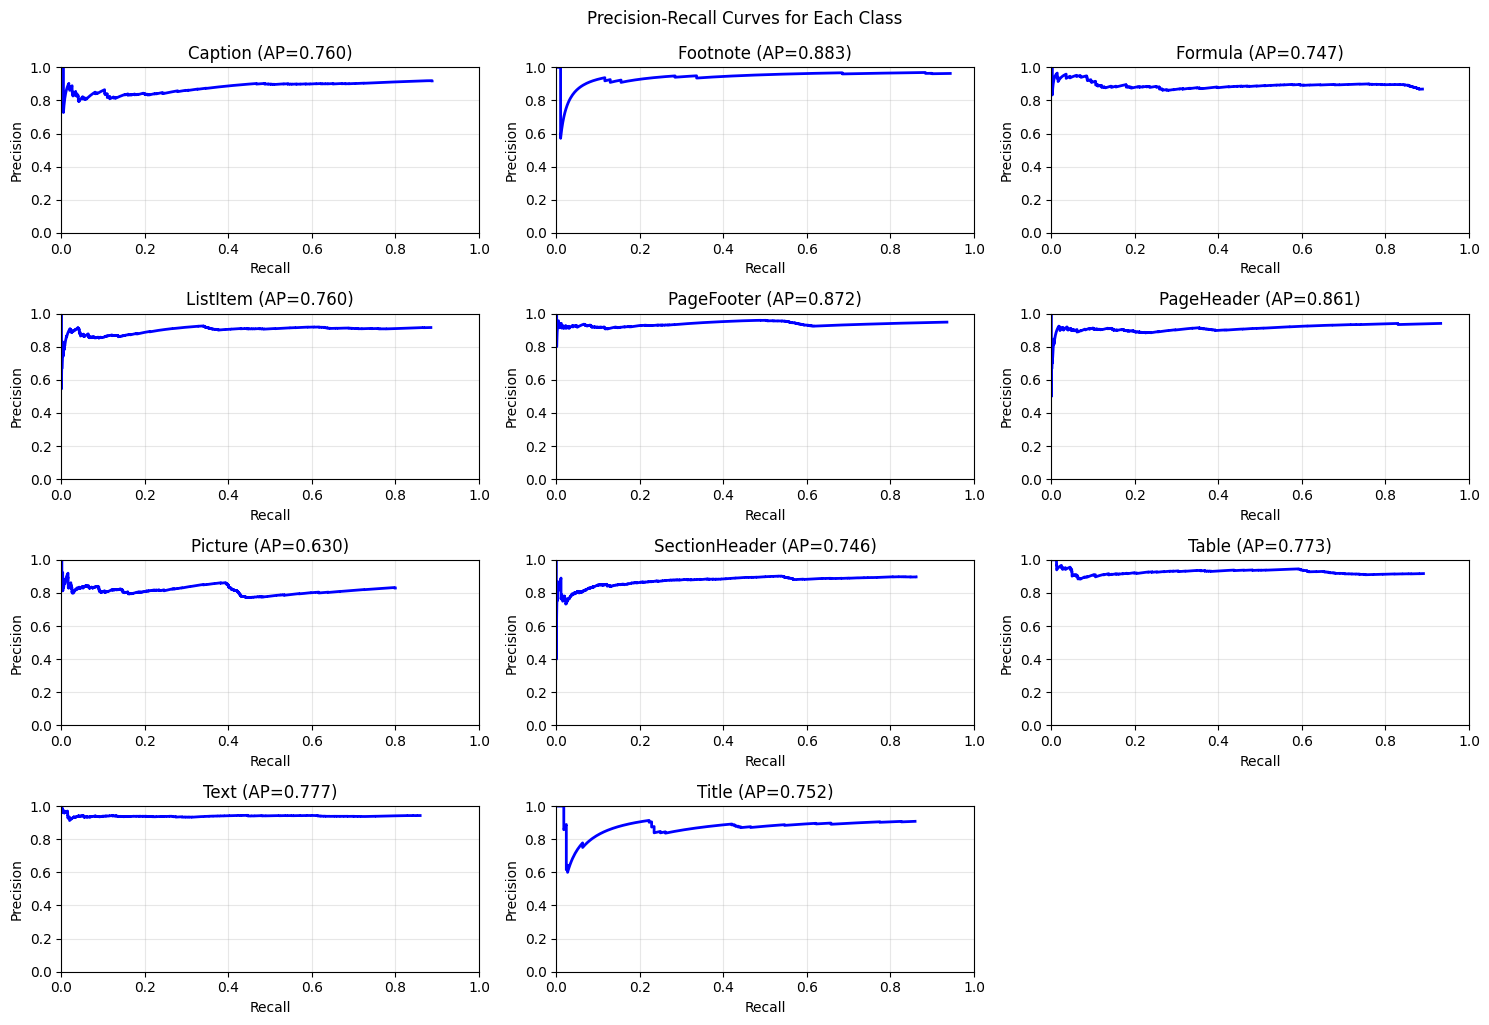


--- Summary ---
Classes evaluated: 11
Classes with AP > 0: 11
mAP: 0.7783


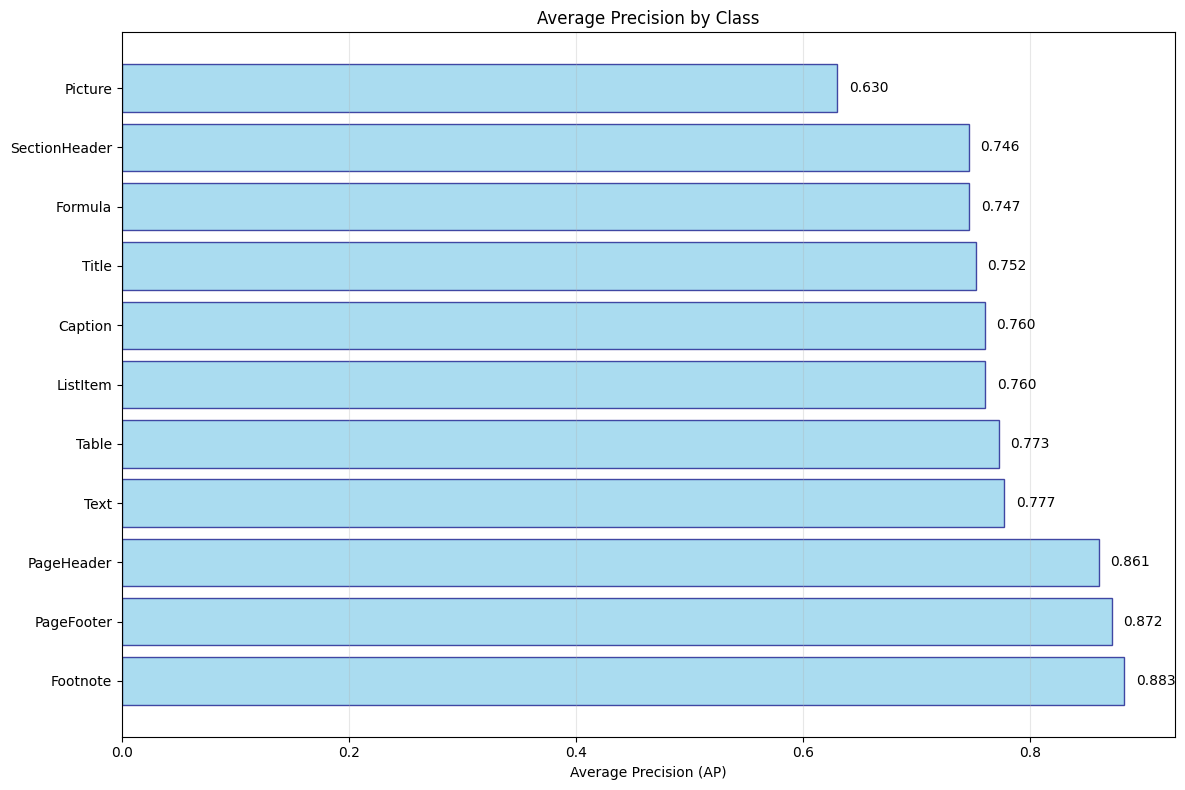


Final Results:
mAP@0.5: 0.7783

Detailed AP Results:
  Footnote: 0.8831
  PageFooter: 0.8720
  PageHeader: 0.8605
  Text: 0.7772
  Table: 0.7727
  ListItem: 0.7605
  Caption: 0.7599
  Title: 0.7523
  Formula: 0.7465
  SectionHeader: 0.7460
  Picture: 0.6302

Evaluation Complete.


In [9]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from sklearn.metrics import precision_recall_curve, average_precision_score
from datasets import load_from_disk

# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5  # IoU threshold for TP/FP/FN determination
NUM_SAMPLES = None  # e.g., 100
CONFIDENCE_SCORE = 1.0  # Constant confidence score since model doesn't output confidence

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea + 1e-6  # Epsilon for stability
    iou = interArea / unionArea
    return iou

def calculate_ap_from_pr_curve(precision, recall):
    """
    Calculate Average Precision (AP) using the precision-recall curve.
    Uses the 11-point interpolation method (PASCAL VOC style).
    """
    if len(precision) == 0 or len(recall) == 0:
        return 0.0
    
    # Sort by recall
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    
    # Add endpoints
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))
    
    # Compute the precision envelope
    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])
    
    # Calculate AP using 11-point interpolation
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        # Find the maximum precision for recall >= t
        p = np.max(precision[recall >= t]) if np.any(recall >= t) else 0.0
        ap += p / 11.0
    
    return ap

def evaluate_layout_model_for_ap(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model for AP calculation.
    Returns detection results for each class with confidence scores and match status.
    """
    # Store detection results for each class
    class_detections = defaultdict(list)  # {class_name: [{'confidence': float, 'matched': bool, 'iou': float}]}
    class_gt_counts = defaultdict(int)  # {class_name: total_gt_count}
    
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # --- Data Validation and Preparation ---
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                continue
            if not isinstance(gt_category_ids, list):
                gt_category_ids = []
            elif gt_category_ids and not isinstance(gt_category_ids[0], int):
                if len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                    gt_category_ids = gt_category_ids[0]
                elif not all(isinstance(item, int) for item in gt_category_ids):
                    print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                    continue

            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                    class_gt_counts[label] += 1

            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                processed_samples += 1
                continue

            # --- Run Inference for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt)
                if not class_label:
                    continue

                # --- Run Inference ---
                try:
                    inference_example = {'image': image, 'input_ids': example.get('input_ids'), 'subword_bboxs': example.get('subword_bboxs')}
                    inference_output = run_example(task_prompt=prompt, example=inference_example)

                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])
                    filtered_pred_boxes = [box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label]
                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    filtered_pred_boxes = []

                # --- Match Predictions to Ground Truth ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_pred == 0:
                    continue

                gt_matched = [False] * num_gt
                
                # For each prediction, find the best matching ground truth
                for pred_box in filtered_pred_boxes:
                    if not isinstance(pred_box, list) or len(pred_box) != 4:
                        print(f"Warning: Invalid prediction box format skipped: {pred_box}")
                        class_detections[class_label].append({
                            'confidence': CONFIDENCE_SCORE,
                            'matched': False,
                            'iou': 0.0
                        })
                        continue
                    
                    best_iou = 0.0
                    best_gt_idx = -1
                    
                    # Find the best matching ground truth box
                    for gt_idx, gt_box in enumerate(gt_boxes_cls):
                        if not isinstance(gt_box, list) or len(gt_box) != 4:
                            continue
                        
                        iou = calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                    
                    # Determine if this prediction is a match
                    is_match = False
                    if best_gt_idx != -1 and best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
                        is_match = True
                        gt_matched[best_gt_idx] = True
                    
                    class_detections[class_label].append({
                        'confidence': CONFIDENCE_SCORE,
                        'matched': is_match,
                        'iou': best_iou
                    })

            processed_samples += 1

        except Exception as e:
            print(f"Fatal error processing sample: {e}")
            continue

    print(f"\nProcessed {processed_samples} samples.")
    return class_detections, class_gt_counts

def calculate_ap_and_map(class_detections, class_gt_counts, plot_curves=True):
    """
    Calculate Average Precision (AP) for each class and mean Average Precision (mAP).
    """
    class_aps = {}
    
    if plot_curves:
        plt.figure(figsize=(15, 10))
        num_classes = len(class_detections)
        cols = 3
        rows = (num_classes + cols - 1) // cols
    
    for i, (class_name, detections) in enumerate(sorted(class_detections.items())):
        if len(detections) == 0:
            class_aps[class_name] = 0.0
            print(f"{class_name}: AP = 0.0000 (no detections)")
            continue
        
        # Sort detections by confidence (descending)
        detections_sorted = sorted(detections, key=lambda x: x['confidence'], reverse=True)
        
        # Calculate precision and recall at each threshold
        tp_cumsum = 0
        fp_cumsum = 0
        precisions = []
        recalls = []
        
        total_gt = class_gt_counts[class_name]
        
        for detection in detections_sorted:
            if detection['matched']:
                tp_cumsum += 1
            else:
                fp_cumsum += 1
            
            precision = tp_cumsum / (tp_cumsum + fp_cumsum) if (tp_cumsum + fp_cumsum) > 0 else 0.0
            recall = tp_cumsum / total_gt if total_gt > 0 else 0.0
            
            precisions.append(precision)
            recalls.append(recall)
        
        # Convert to numpy arrays
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        
        # Calculate AP
        if len(precisions) > 0 and len(recalls) > 0:
            ap = calculate_ap_from_pr_curve(precisions, recalls)
        else:
            ap = 0.0
        
        class_aps[class_name] = ap
        
        print(f"{class_name}: AP = {ap:.4f} (GT: {total_gt}, Det: {len(detections)})")
        
        # Plot precision-recall curve
        if plot_curves and len(precisions) > 0:
            plt.subplot(rows, cols, i + 1)
            plt.plot(recalls, precisions, 'b-', linewidth=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'{class_name} (AP={ap:.3f})')
            plt.grid(True, alpha=0.3)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
    
    if plot_curves:
        plt.tight_layout()
        plt.suptitle('Precision-Recall Curves for Each Class', y=1.02)
        plt.show()
    
    # Calculate mAP
    valid_aps = [ap for ap in class_aps.values() if ap > 0]
    map_score = np.mean(list(class_aps.values())) if class_aps else 0.0
    
    print(f"\n--- Summary ---")
    print(f"Classes evaluated: {len(class_aps)}")
    print(f"Classes with AP > 0: {len(valid_aps)}")
    print(f"mAP: {map_score:.4f}")
    
    return class_aps, map_score

def plot_ap_comparison(class_aps):
    """Plot AP comparison across classes."""
    plt.figure(figsize=(12, 8))
    
    classes = list(class_aps.keys())
    aps = list(class_aps.values())
    
    # Sort by AP value
    sorted_data = sorted(zip(classes, aps), key=lambda x: x[1], reverse=True)
    classes, aps = zip(*sorted_data)
    
    plt.barh(range(len(classes)), aps, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Average Precision (AP)')
    plt.title('Average Precision by Class')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, ap in enumerate(aps):
        plt.text(ap + 0.01, i, f'{ap:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings ---
    prompt_to_label_map = {
        "<CAP>": "Caption",
        "<FN>": "Footnote",
        "<FRM>": "Formula",
        "<LST>": "ListItem",
        "<PGF>": "PageFooter",
        "<PGH>": "PageHeader",
        "<PIC>": "Picture",
        "<SHD>": "SectionHeader",
        "<TAB>": "Table",
        "<TXT>": "Text",
        "<TTL>": "Title",
    }

    # Check if id2label is defined
    if 'id2label' not in globals():
        print("Error: 'id2label' mapping is not defined in the environment. Please load or define it.")
        import sys
        sys.exit(1)

    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    # Load dataset
    dataset = load_from_disk("/home/muddassir/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")
    print("dataset loaded")
    # # Optional: Random sampling
    # import random
    # num_samples = None
    # random_indices = random.sample(range(len(dataset)), num_samples)
    # dataset = dataset.select(random_indices)

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label.")

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # Run the evaluation for AP calculation
        class_detections, class_gt_counts = evaluate_layout_model_for_ap(
            dataset=dataset,
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate AP and mAP
        if class_detections:
            class_aps, map_score = calculate_ap_and_map(
                class_detections, 
                class_gt_counts, 
                plot_curves=True
            )
            
            # Plot AP comparison
            plot_ap_comparison(class_aps)
            
            print(f"\nFinal Results:")
            print(f"mAP@{IOU_THRESHOLD}: {map_score:.4f}")
            
            # Print detailed results
            print("\nDetailed AP Results:")
            for class_name, ap in sorted(class_aps.items(), key=lambda x: x[1], reverse=True):
                print(f"  {class_name}: {ap:.4f}")
                
        else:
            print("No detections found to calculate AP.")

        print("\nEvaluation Complete.")

In [8]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time # Optional: for timing inference




# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5 # IoU threshold for TP/FP/FN determination
# Limit the number of samples for testing (set to None to use the full dataset)
NUM_SAMPLES = None # e.g., 100

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea + 1e-6 # Epsilon for stability
    iou = interArea / unionArea
    return iou

def evaluate_layout_model(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model, calculating TP, FP, FN, and sum of IoUs for TPs.
    Only prompts for classes present in the ground truth of each image.

    Args:
        dataset: The dataset object (Hugging Face dataset).
        prompt_map: Dictionary mapping prompt strings to label strings (e.g., "<TXT>": "Text").
        label_map_rev: Dictionary mapping label strings to prompt strings (e.g., "Text": "<TXT>").
        iou_threshold: The IoU threshold for matching predictions to ground truth.
        num_samples: Max number of samples to evaluate on (or None for all).

    Returns:
        A tuple: (results, all_tp_iou_sum)
          - results: Dictionary containing evaluation results per class
                     (TP, FP, FN, tp_iou_sum).
          - all_tp_iou_sum: Float, the total sum of IoU values for all True Positives across all classes.
    """
    # Initialize results dict, adding 'tp_iou_sum'
    results = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'tp_iou_sum': 0.0})
    all_tp_iou_sum = 0.0 # Accumulator for overall average IoU calculation
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # --- Data Validation and Preparation ---
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                 print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                 continue
            if not isinstance(gt_category_ids, list): # Allow empty list
                gt_category_ids = []
            elif gt_category_ids and not isinstance(gt_category_ids[0], int):
                 if len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                     gt_category_ids = gt_category_ids[0] # Handle nested list case
                 elif not all(isinstance(item, int) for item in gt_category_ids):
                      print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                      continue

            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                # else: Silently ignore unknown category IDs

            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                processed_samples+=1
                continue
            # --- End Data Validation ---


            # --- Run Inference ONLY for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt)
                if not class_label: continue

                # --- Run Inference ---
                try:
                    # start_time = time.time() # Optional timing
                    inference_example = {'image': image, 'input_ids': example.get('input_ids'), 'subword_bboxs': example.get('subword_bboxs')}
                    inference_output = run_example(task_prompt=prompt, example=inference_example)
                    # print(f"Inference time for {prompt}: {time.time() - start_time:.2f}s") # Optional

                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])
                    filtered_pred_boxes = [box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label]
                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    filtered_pred_boxes = []
                # --- End Inference ---


                # --- Match Predictions to Ground Truth ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_gt == 0 and num_pred == 0: continue

                gt_matched = [False] * num_gt
                pred_matched = [False] * num_pred
                tp = 0
                current_tp_iou_sum = 0.0 # Sum IoUs for TPs *in this image/class*

                if num_pred > 0 and num_gt > 0:
                    iou_matrix = np.zeros((num_pred, num_gt))
                    valid_preds = [] # Store indices of valid predictions
                    for p_idx, p_box in enumerate(filtered_pred_boxes):
                        if not isinstance(p_box, list) or len(p_box) != 4:
                            print(f"Warning: Invalid prediction box format skipped: {p_box}")
                            continue
                        valid_preds.append(p_idx) # Track valid prediction index
                        valid_gt = [] # Store indices of valid ground truths for this pred
                        for g_idx, g_box in enumerate(gt_boxes_cls):
                            if not isinstance(g_box, list) or len(g_box) != 4:
                                # This check might be redundant if GT is clean, but safe
                                print(f"Warning: Invalid ground truth box format skipped: {g_box}")
                                continue
                            valid_gt.append(g_idx) # Track valid GT index
                            # Calculate IoU only between valid boxes
                            iou_matrix[p_idx, g_idx] = calculate_iou(p_box, g_box)

                    # Ensure we only consider valid boxes in matching
                    if valid_preds and valid_gt:
                         # Consider only the submatrix of valid preds/GTs for matching
                         valid_iou_matrix = iou_matrix[np.ix_(valid_preds, valid_gt)]
                         potential_matches = np.argwhere(valid_iou_matrix >= iou_threshold)

                         if potential_matches.size > 0:
                            # Map indices back to original filtered_pred_boxes and gt_boxes_cls
                            original_p_indices = [valid_preds[i] for i in potential_matches[:, 0]]
                            original_g_indices = [valid_gt[i] for i in potential_matches[:, 1]]

                            iou_values = valid_iou_matrix[potential_matches[:, 0], potential_matches[:, 1]]
                            sorted_indices = np.argsort(iou_values)[::-1] # Sort descending

                            for idx in sorted_indices:
                                p_idx = original_p_indices[idx] # Original index in filtered_pred_boxes
                                g_idx = original_g_indices[idx] # Original index in gt_boxes_cls

                                # Check if boxes (by original index) are already matched
                                if not pred_matched[p_idx] and not gt_matched[g_idx]:
                                    tp += 1
                                    pred_matched[p_idx] = True
                                    gt_matched[g_idx] = True
                                    # Accumulate IoU for this specific TP match
                                    iou_value = iou_matrix[p_idx, g_idx] # Get the actual IoU
                                    current_tp_iou_sum += iou_value


                # Calculate FP, FN for this class/image
                fp = sum(1 for p_idx, p_box in enumerate(filtered_pred_boxes) if not pred_matched[p_idx] and isinstance(p_box, list) and len(p_box) == 4) # Count only valid unmatched preds as FP
                fn = num_gt - sum(gt_matched)

                # Accumulate results for the class across all images
                results[class_label]['tp'] += tp
                results[class_label]['fp'] += fp
                results[class_label]['fn'] += fn
                results[class_label]['tp_iou_sum'] += current_tp_iou_sum # Add sum for this image/class

            processed_samples += 1 # Increment after successfully processing all prompts for the image

        except Exception as e:
            print(f"Fatal error processing sample (Index maybe unreliable if dataset shuffled): {e}")
            # Optionally log sample ID if available: example.get('image_id', 'Unknown')
            continue # Move to the next sample

    # --- Calculate total IoU sum after processing all samples ---
    # Sum up the per-class IoU sums collected in the results dict
    all_tp_iou_sum = sum(counts.get('tp_iou_sum', 0.0) for counts in results.values())

    print(f"\nProcessed {processed_samples} samples.")
    if processed_samples == 0:
         print("Warning: No samples were processed successfully.")

    return results, all_tp_iou_sum # Return both results dict and total IoU sum

def calculate_metrics(results, all_tp_iou_sum):
    """Calculates Precision, Recall, F1, and Avg IoU from TP, FP, FN counts."""
    metrics = {}
    all_tp, all_fp, all_fn = 0, 0, 0

    valid_labels = [label for label, counts in results.items() if counts['tp'] > 0 or counts['fp'] > 0 or counts['fn'] > 0]

    if not valid_labels:
        print("\nNo valid results found to calculate metrics.")
        return {}

    print("\n--- Per-Class Metrics ---")
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_avg_ious = [] # To calculate overall average IoU correctly later if needed

    for label in sorted(valid_labels): # Sort for consistent output
        counts = results[label]
        tp = counts['tp']
        fp = counts['fp']
        fn = counts['fn']
        tp_iou_sum = counts.get('tp_iou_sum', 0.0) # Get the sum of IoUs for TPs

        all_tp += tp
        all_fp += fp
        all_fn += fn

        # Calculate P, R, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        # Calculate Average IoU for TPs of this class
        avg_iou_class = tp_iou_sum / tp if tp > 0 else 0.0
        if tp > 0:
            class_avg_ious.append(avg_iou_class) # Store for potential macro avg IoU

        metrics[label] = {
            'precision': precision, 'recall': recall, 'f1': f1,
            'avg_iou': avg_iou_class, # Add avg IoU here
            'tp': tp, 'fp': fp, 'fn': fn
        }
        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)

        # Print metrics for the class
        print(f"{label}:")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  Avg TP IoU:{avg_iou_class:.4f}") # Print avg IoU

    # --- Overall Metrics (Micro Average) ---
    # Micro P, R, F1 are calculated based on total TP, FP, FN
    micro_precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0.0
    micro_recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0.0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0

    # Overall Average IoU is calculated based on total sum of TP IoUs and total TPs
    overall_avg_iou = all_tp_iou_sum / all_tp if all_tp > 0 else 0.0

    metrics['overall_micro'] = {
        'precision': micro_precision, 'recall': micro_recall, 'f1': micro_f1,
        'avg_iou': overall_avg_iou, # Add overall avg IoU here
        'tp': all_tp, 'fp': all_fp, 'fn': all_fn
    }
    print("\n--- Overall Metrics (Micro Average) ---")
    print(f"Total TP: {all_tp}, Total FP: {all_fp}, Total FN: {all_fn}")
    print(f"Precision: {micro_precision:.4f}")
    print(f"Recall:    {micro_recall:.4f}")
    print(f"F1-Score:  {micro_f1:.4f}")
    print(f"Avg TP IoU:{overall_avg_iou:.4f}") # Print overall avg IoU

    # --- Overall Metrics (Macro Average) ---
    num_classes_evaluated = len(valid_labels)
    if num_classes_evaluated > 0:
        macro_precision = sum(class_precisions) / num_classes_evaluated
        macro_recall = sum(class_recalls) / num_classes_evaluated
        if (macro_precision + macro_recall) > 0:
            macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        else:
            macro_f1 = 0.0
        # Optional: Macro Average IoU (average of per-class average IoUs)
        # macro_avg_iou = sum(class_avg_ious) / len(class_avg_ious) if class_avg_ious else 0.0
    else:
        macro_precision, macro_recall, macro_f1 = 0.0, 0.0, 0.0
        # macro_avg_iou = 0.0

    metrics['overall_macro'] = {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1}
    print("\n--- Overall Metrics (Macro Average) ---")
    print(f"Averaged over {num_classes_evaluated} classes: {', '.join(sorted(valid_labels))}")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1-Score:  {macro_f1:.4f}")
    # print(f"Avg TP IoU:{macro_avg_iou:.4f}") # Optional: print macro avg IoU

    return metrics

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings (Essential!) ---
    # Ensure id2label is defined and available from your setup
    # Ensure your prompts align with the desired labels

    # prompt_to_label_map = {
    #     "<CAP>": "Caption", "<FTN>": "Footnote", "<FRM>": "Formula", "<LST>": "ListItem",
    #     "<PGF>": "PageFooter", "<PGH>": "PageHeader", "<PIC>": "Picture", "<SHD>": "SectionHeader",
    #     "<TAB>": "Table", "<TXT>": "Text", "<TTL>": "Title",
    #     # Add any other prompts your model uses
    # }



    prompt_to_label_map = {
    "<CAP>":"Caption",
    "<FN>": "Footnote",  # Changed from <FTN>
    "<FRM>":"Formula",
    "<LST>":"ListItem",
    "<PGF>":"PageFooter",
    "<PGH>":"PageHeader",
    "<PIC>":"Picture",
    "<SHD>":"SectionHeader",
    "<TAB>":"Table",
    "<TXT>":"Text",
    "<TTL>":"Title",
}

    # Filter mappings based on labels actually in id2label
    # Check if id2label is defined
    if 'id2label' not in globals():
         print("Error: 'id2label' mapping is not defined in the environment. Please load or define it.")
         # Exit or raise error
         import sys
         sys.exit(1)

    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    dataset = load_from_disk("/home/docanalysis/florence2-training/dataset_florence2_td/test")
    import random
    num_samples = 1000

# Randomly select indices
    random_indices = random.sample(range(len(dataset)), num_samples)

# Get the samples
    dataset = dataset.select(random_indices)

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label.")

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # --- Ensure dataset is loaded ---
        if 'dataset' not in globals():
            print("Error: 'dataset' is not defined. Please load your dataset.")
            import sys
            sys.exit(1)

        # Run the evaluation - it now returns two values
        evaluation_results, total_tp_iou_sum = evaluate_layout_model(
            dataset=dataset, # Pass the raw dataset
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate and print metrics - pass the total IoU sum
        if evaluation_results:
            final_metrics = calculate_metrics(evaluation_results, total_tp_iou_sum)
        else:
            print("Evaluation did not produce results.")

        print("\nEvaluation Complete.")

Using 11 mappings based on id2label.


Evaluating Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribute 'get'
Error during inference for sample, prompt <FN>: 'str' object has no attribut

In [26]:
import datasets
VAL_SPLIT_NAME = "val"
VAL_DATA = '/home/docanalysis/florence2-training/dataset_florence2_td/val'
val_dataset = datasets.load_from_disk(
        VAL_DATA, VAL_SPLIT_NAME)

In [31]:
val_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1025x1025>,
 'category_ids': [7, 10, 9, 10, 5],
 'image_id': 0,
 'boxes': [[768.334228515625,
   30.909997940063477,
   977.3663330078125,
   101.07078552246094],
  [161.42921447753906, 199.2574005126953, 299.443359375, 209.09738159179688],
  [159.44190979003906,
   210.97300720214844,
   873.7918701171875,
   864.4987182617188],
  [182.7205352783203, 872.0671997070312, 537.7703857421875, 893.6886596679688],
  [920.2300415039062, 986.4758911132812, 941.6699829101562, 996.31591796875]],
 'width': 1025,
 'height': 1025,
 'bbox_str': 'Picture<loc_749><loc_30><loc_953><loc_98>Text<loc_157><loc_194><loc_292><loc_203><loc_178><loc_850><loc_524><loc_871>Table<loc_155><loc_205><loc_852><loc_843>PageFooter<loc_897><loc_962><loc_918><loc_972>',
 'class_strs': ['Picture<loc_749><loc_30><loc_953><loc_98>',
  'Text<loc_157><loc_194><loc_292><loc_203><loc_178><loc_850><loc_524><loc_871>',
  'Table<loc_155><loc_205><loc_852><loc_843>',
  

In [32]:
val_dataset[0]["input_ids"]

[19446,
 2005,
 1996,
 2095,
 3092,
 2382,
 2238,
 1019,
 1012,
 11443,
 18376,
 1998,
 3037,
 2363,
 11443,
 18376,
 2363,
 1516,
 20178,
 1022,
 5345,
 2683,
 1023,
 6421,
 17788,
 5764,
 2581,
 3037,
 2363,
 1516,
 20178,
 1015,
 1018,
 1015,
 1516,
 2060,
 1016,
 2538,
 1022,
 5986,
 2475,
 1023,
 6421,
 2620,
 1019,
 5764,
 2683,
 1020,
 1012,
 23733,
 5366,
 3037,
 3825,
 2000,
 20178,
 1517,
 1017,
 1517,
 1021,
 1012,
 14952,
 2148,
 3060,
 3671,
 4171,
 1516,
 2783,
 2095,
 2340,
 4029,
 1018,
 1516,
 25416,
 8630,
 1999,
 4847,
 1997,
 6381,
 4383,
 7506,
 1517,
 1006,
 2484,
 1007,
 1517,
 2340,
 13412,
 16088,
 1997,
 4621,
 4171,
 3446,
 1003,
 1003,
 1003,
 2148,
 3060,
 3671,
 4171,
 3446,
 2382,
 1010,
 1014,
 2382,
 1010,
 1014,
 2382,
 1010,
 1014,
 3623,
 1999,
 4171,
 3446,
 2349,
 2000,
 1024,
 1516,
 4487,
 12002,
 27663,
 2094,
 20700,
 1014,
 1010,
 1017,
 1014,
 1010,
 1017,
 1014,
 1010,
 1015,
 2382,
 1010,
 1017,
 2382,
 1010,
 1017,
 2382,
 1010,
 1015,
 98

# Debugging

In [10]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json

# Your existing model setup code here (CHECKPOINT_PATH, config_f, model_f, processor_f)
# I'm assuming these are already loaded from your script

def debug_run_example(task_prompt, example, max_new_tokens=128, input_text: str = None):
    """Debug version of run_example that prints detailed output"""
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    
    print(f"\n=== DEBUGGING PROMPT: {task_prompt} ===")
    print(f"Full prompt: '{prompt}'")
    
    image = example["image"]
    input_ids = torch.tensor(example['input_ids'])
    bbox = torch.tensor(example['subword_bboxs'])
    
    inputs = processor_f(text=prompt, images=image, return_tensors="pt")
    inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
    
    print(f"Input shape - input_ids: {inputs['input_ids'].shape}")
    print(f"Input shape - pixel_values: {inputs['pixel_values'].shape}")
    
    generated_ids = model_f.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].half().to(device),
        grid_data=inputs['grid_data'],
        max_new_tokens=max_new_tokens,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    
    generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
    print(f"\nGenerated text (raw): '{generated_text}'")
    print(f"Generated text type: {type(generated_text)}")
    print(f"Generated text length: {len(generated_text)}")
    
    try:
        parsed_answer = processor_f.post_process_generation(
            generated_text, task=task_prompt, image_size=(image.width, image.height)
        )
        print(f"\nParsed answer type: {type(parsed_answer)}")
        print(f"Parsed answer: {parsed_answer}")
        
        if isinstance(parsed_answer, dict):
            print(f"Parsed answer keys: {list(parsed_answer.keys())}")
            for key, value in parsed_answer.items():
                print(f"  {key}: {type(value)} - {value}")
        elif isinstance(parsed_answer, str):
            print(f"Parsed answer is a string: '{parsed_answer}'")
        else:
            print(f"Parsed answer is of unexpected type: {type(parsed_answer)}")
            
    except Exception as e:
        print(f"Error in post_process_generation: {e}")
        parsed_answer = generated_text
        
    return parsed_answer

def debug_specific_prompts(dataset, debug_prompts=["<FN>"], num_samples=5):
    """Debug specific prompts on a few samples"""
    
    print(f"=== DEBUGGING PROMPTS: {debug_prompts} ===")
    print(f"Testing on {num_samples} samples\n")
    
    # Get samples that have the labels we're interested in
    samples_to_test = []
    
    for idx, example in enumerate(dataset):
        if len(samples_to_test) >= num_samples:
            break
            
        try:
            gt_category_ids = example.get('category_ids', [])
            if isinstance(gt_category_ids, list) and gt_category_ids:
                if isinstance(gt_category_ids[0], list):
                    gt_category_ids = gt_category_ids[0]
                
                # Check if any of our debug prompts correspond to labels in this sample
                gt_labels_present = set()
                for cat_id in gt_category_ids:
                    if cat_id in id2label:
                        label = id2label[cat_id]
                        gt_labels_present.add(label)
                
                # Check if any debug prompt corresponds to present labels
                prompt_to_label_map = {
                    "<CAP>": "Caption",
                    "<FN>": "Footnote",
                    "<FRM>": "Formula",
                    "<LST>": "ListItem",
                    "<PGF>": "PageFooter",
                    "<PGH>": "PageHeader",
                    "<PIC>": "Picture",
                    "<SHD>": "SectionHeader",
                    "<TAB>": "Table",
                    "<TXT>": "Text",
                    "<TTL>": "Title",
                }
                
                relevant_prompts = []
                for prompt in debug_prompts:
                    if prompt in prompt_to_label_map:
                        label = prompt_to_label_map[prompt]
                        if label in gt_labels_present:
                            relevant_prompts.append(prompt)
                
                if relevant_prompts:
                    samples_to_test.append((idx, example, relevant_prompts))
                    print(f"Sample {idx}: Found labels {gt_labels_present}")
                    print(f"  Will test prompts: {relevant_prompts}")
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            continue
    
    if not samples_to_test:
        print("No samples found with the target labels. Testing on first few samples anyway...")
        samples_to_test = [(i, dataset[i], debug_prompts) for i in range(min(num_samples, len(dataset)))]
    
    # Now run debug inference on these samples
    for sample_idx, example, prompts_to_test in samples_to_test:
        print(f"\n{'='*60}")
        print(f"TESTING SAMPLE {sample_idx}")
        print(f"{'='*60}")
        
        for prompt in prompts_to_test:
            try:
                inference_example = {
                    'image': example['image'], 
                    'input_ids': example.get('input_ids'), 
                    'subword_bboxs': example.get('subword_bboxs')
                }
                
                result = debug_run_example(task_prompt=prompt, example=inference_example)
                
                print(f"\n--- SUMMARY for {prompt} ---")
                print(f"Result type: {type(result)}")
                if isinstance(result, dict):
                    print(f"Keys: {list(result.keys())}")
                    # Try to access it the way your evaluation script does
                    try:
                        pred_data = result.get(prompt, {'bboxes': [], 'labels': []})
                        print(f"Successfully accessed result.get('{prompt}'): {pred_data}")
                    except Exception as e:
                        print(f"Error accessing result.get('{prompt}'): {e}")
                elif isinstance(result, str):
                    print(f"String result: '{result[:200]}...' (truncated)")
                
            except Exception as e:
                print(f"ERROR testing {prompt} on sample {sample_idx}: {e}")
                import traceback
                traceback.print_exc()

# Main debug execution
if __name__ == "__main__":
    # Load your dataset
    dataset = load_from_disk("/home/docanalysis/florence2-training/dataset_florence2_td/test")
    
    # Debug the <FN> prompt specifically
    debug_specific_prompts(dataset, debug_prompts=["<FN>"], num_samples=3)
    
    # You can also test other prompts for comparison
    print(f"\n{'='*80}")
    print("COMPARING WITH OTHER PROMPTS")
    print(f"{'='*80}")
    debug_specific_prompts(dataset, debug_prompts=["<TXT>", "<FN>"], num_samples=2)

=== DEBUGGING PROMPTS: ['<FN>'] ===
Testing on 3 samples

Sample 3: Found labels {'SectionHeader', 'Footnote', 'Picture', 'PageFooter', 'Text'}
  Will test prompts: ['<FN>']
Sample 39: Found labels {'SectionHeader', 'PageHeader', 'Footnote', 'Picture', 'PageFooter', 'Text'}
  Will test prompts: ['<FN>']
Sample 108: Found labels {'SectionHeader', 'PageHeader', 'Footnote', 'Picture', 'PageFooter', 'Text'}
  Will test prompts: ['<FN>']

TESTING SAMPLE 3

=== DEBUGGING PROMPT: <FN> ===
Full prompt: '<FN>'
Input shape - input_ids: torch.Size([1, 5])
Input shape - pixel_values: torch.Size([1, 3, 768, 768])

Generated text (raw): '</s><s>Text<loc_103><loc_122><loc_999><loc_232><loc_105><loc_246><loc_930><loc_333><loc_105><loc_334><loc_594><loc_509><loc_105><loc_524><loc_594><loc_682><loc_105><loc_704><loc_598><loc_738><loc_105><loc_742><loc_869><loc_798><loc_105><loc_815><loc_839><loc_853><loc_666><loc_632><loc_968><loc_706><loc_666><loc_443><loc_970><loc_616></s>'
Generated text type: <class

In [ ]:
CLASS_WEIGHTS = {
    'Caption': 0.0849,
    'Footnote': 0.3881,  # Increased from 0.2881
    'Formula': 0.0767,
    'ListItem': 0.0400,
    'PageFooter': 0.0365,
    'PageHeader': 0.0339,
    'Picture': 0.0610,
    'SectionHeader': 0.0137,
    'Table': 0.0540,
    'Text': 0.0538,
    'Title': 0.2574,  
}

In [13]:
CLASS_WEIGHTS = {
    'Caption': 0.0849,
    'Footnote': 0.4881,  # Increased from 0.2881
    'Formula': 0.0767,
    'ListItem': 0.0100,
    'PageFooter': 0.0265,
    'PageHeader': 0.0339,
    'Picture': 0.0410,
    'SectionHeader': 0.0137,
    'Table': 0.0540,
    'Text': 0.0038,
    'Title': 0.2674,  # Reduced from 0.3674 to balance
}

In [14]:
sum(list(CLASS_WEIGHTS.values()))

1.1

In [ ]:
Processed 4998 samples.
Caption: AP = 0.7599 (GT: 1543, Det: 1492)
Footnote: AP = 0.8831 (GT: 387, Det: 379)
Formula: AP = 0.7465 (GT: 1966, Det: 2011)
ListItem: AP = 0.7605 (GT: 10512, Det: 10156)
PageFooter: AP = 0.8720 (GT: 3994, Det: 3938)
PageHeader: AP = 0.8605 (GT: 3364, Det: 3334)
Picture: AP = 0.6302 (GT: 3534, Det: 3406)
SectionHeader: AP = 0.7460 (GT: 8550, Det: 8213)
Table: AP = 0.7727 (GT: 2394, Det: 2326)
Text: AP = 0.7772 (GT: 29938, Det: 27278)
Title: AP = 0.7523 (GT: 333, Det: 315)